# SKLearn Spacy Reddit Text Classification Example

In this example we will be buiding a text classifier using the reddit content moderation dataset.

For this, we will be using SpaCy for the word tokenization and lemmatization. 

The classification will be done with a Logistic Regression binary classifier.

The steps in this tutorial include:

1) Train and build your NLP model

2) Build your containerized model

3) Test your model as a docker container

4) Run Seldon in your kubernetes cluster

5) Deploy your model with Seldon

6) Interact with your model through API

7) Clean your environment


### Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* Python 3.6+
* Python DEV requirements (we'll install them below)

Let's get started! 🚀🔥

## 1) Train and build your NLP model

In [ ]:
# Let's first install any dependencies
!pip install -r requirements.txt

In [21]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from seldon_core.seldon_client import SeldonClient
import dill
import sys, os

# This import may take a while as it will download the Spacy ENGLISH model
from ml_utils import CleanTextTransformer, SpacyTokenTransformer

In [24]:
df_cols = ["prev_idx", "parent_idx", "body", "removed"]

TEXT_COLUMN = "body" 
CLEAN_COLUMN = "clean_body"
TOKEN_COLUMN = "token_body"

# Downloading the 50k reddit dataset of moderated comments
df = pd.read_csv("https://raw.githubusercontent.com/axsauze/reddit-classification-exploration/master/data/reddit_train.csv", 
                         names=df_cols, skiprows=1, encoding="ISO-8859-1")

df.head()

,prev_idx,parent_idx,body,removed
0,8756,8877,Always be wary of news articles that cite unpu...,0
1,7330,7432,The problem I have with this is that the artic...,0
2,15711,15944,"This is indicative of a typical power law, and...",0
3,1604,1625,This doesn't make sense. Chess obviously trans...,0
4,13327,13520,1. I dispute that gene engineering is burdenso...,0


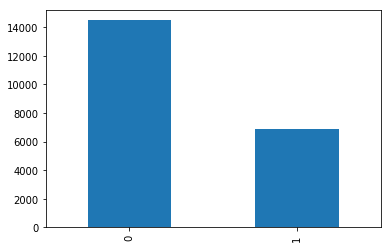

In [25]:
# Let's see how many examples we have of each class
df["removed"].value_counts().plot.bar()

In [26]:
x = df["body"].values
y = df["removed"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True)

In [27]:
# Clean the text
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)

In [28]:
# Tokenize the text and get the lemmas
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)

In [29]:
# Build tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    preprocessor=lambda x: x, 
    tokenizer=lambda x: x, 
    token_pattern=None,
    ngram_range=(1, 3))

tfidf_vectorizer.fit(x_train_tokenized)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function <lambda> at 0x7fcda0a72950>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=None,
        tokenizer=<function <lambda> at 0x7fcda0a72730>, use_idf=True,
        vocabulary=None)

In [30]:
# Transform our tokens to tfidf vectors
x_train_tfidf = tfidf_vectorizer.transform(
    x_train_tokenized)

In [31]:
# Train logistic regression classifier
lr = LogisticRegression(C=0.1, solver='sag')
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
# These are the models we'll deploy
with open('tfidf_vectorizer.model', 'wb') as model_file:
    dill.dump(tfidf_vectorizer, model_file)
with open('lr.model', 'wb') as model_file:
    dill.dump(lr, model_file)

## 2) Build your containerized model

In [33]:
# This is the class we will use to deploy
!cat RedditClassifier.py

import dill

from ml_utils import CleanTextTransformer, SpacyTokenTransformer

class RedditClassifier(object):
    def __init__(self):
        
        self._clean_text_transformer = CleanTextTransformer()
        self._spacy_tokenizer = SpacyTokenTransformer()
        
        with open('tfidf_vectorizer.model', 'rb') as model_file:
            self._tfidf_vectorizer = dill.load(model_file)
           
        with open('lr.model', 'rb') as model_file:
            self._lr_model = dill.load(model_file)

    def predict(self, X, feature_names):
        clean_text = self._clean_text_transformer.transform(X)
        spacy_tokens = self._spacy_tokenizer.transform(clean_text)
        tfidf_features = self._tfidf_vectorizer.transform(spacy_tokens)
        predictions = self._lr_model.predict_proba(tfidf_features)
        return predictions



In [34]:
# test that our model works
from RedditClassifier import RedditClassifier
# With one sample
sample = x_test[0:1]
print(sample)
print(RedditClassifier().predict(sample, ["feature_name"]))

['This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf']
[[0.82767095 0.17232905]]


### Create Docker Image with the S2i utility
Using the S2I command line interface we wrap our current model to seve it through the Seldon interface

In [35]:
# To create a docker image we need to create the .s2i folder configuration as below:
!cat .s2i/environment

MODEL_NAME=RedditClassifier
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


In [36]:
# As well as a requirements.txt file with all the relevant dependencies
!cat requirements.txt

scipy>= 0.13.3
scikit-learn>=0.18
spacy==2.0.18
dill==0.2.9
seldon-core==0.2.7


In [37]:
!s2i build . seldonio/seldon-core-s2i-python3:0.13 reddit-classifier:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl


Stored in directory: /root/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Stored in directory: /root/.cache/pip/wheels/74/17/3f/c77bba99efd74ba1a19862c9dd97f4b6d735e2826721dc00ff
Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Stored in directory: /root/.cache/pip/wheels/88/f3/11/9817b001e59ab04889e8cffcbd9087e2e2155b9ebecfc8dd38
Stored in directory: /root/.cache/pip/wheels/f4/0c/f6/ce6b2d1aa459ee97cc3c0f82236302bd62d89c86c700219463
Successfully built dill ujson regex wrapt cytoolz toolz
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## 3) Test your model as a docker container

In [38]:
# Remove previously deployed containers for this model
!docker rm -f reddit_predictor

Error: No such container: reddit_predictor


In [39]:
!docker run --name "reddit_predictor" -d --rm -p 5001:5000 reddit-classifier:0.1

be29c6a00adec0f708dc5a1c83613e0656fddc06daba4ca02d93b5a7ece9b92b


### Make sure you wait for language model
SpaCy will download the English language model, so you have to make sure the container finishes downloading it before it can be used. You can view this by running the logs until you see "Linking successful".

In [40]:
# Here we need to wait until we see "Linking successful", as it's downloading the Spacy English model
# You can hit stop when this happens
!docker logs -t -f reddit_predictor

2019-05-27T13:50:12.739381600Z starting microservice
2019-05-27T13:50:14.023399000Z 2019-05-27 13:50:14,023 - seldon_core.microservice:main:154 - INFO:  Starting microservice.py:main
2019-05-27T13:50:14.024836400Z 2019-05-27 13:50:14,024 - seldon_core.microservice:main:185 - INFO:  Annotations: {}
2019-05-27T13:50:14.686919400Z Collecting en_core_web_sm==2.0.0 from https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz#egg=en_core_web_sm==2.0.0
2019-05-27T13:50:15.402484400Z   Downloading https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz (37.4MB)
2019-05-27T13:50:47.771818100Z Building wheels for collected packages: en-core-web-sm
2019-05-27T13:50:47.772287600Z   Building wheel for en-core-web-sm (setup.py): started
2019-05-27T13:50:49.845376700Z   Building wheel for en-core-web-sm (setup.py): finished with status 'done'
2019-05-27T13:50:49.845641500Z   Stored in directory: 

In [43]:
# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5001"
batch = sample
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)
response = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

print(response)

Success:True message:
Request:
data {
  names: "tfidf"
  ndarray {
    values {
      string_value: "This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf"
    }
  }
}

Response:
meta {
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.8276709475641506
        }
        values {
          number_value: 0.1723290524358494
        }
      }
    }
  }
}



In [44]:
# We now stop it to run it in docker
!docker stop reddit_predictor

reddit_predictor


## 4) Run Seldon in your kubernetes cluster


## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

## 5) Deploy your model with Seldon
We can now deploy our model by using the Seldon graph definition:

In [60]:
# We'll use our seldon deployment file
!cat reddit_clf.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "reddit-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Reddit classifier",
            "deployment_version": "v1"
        },
        "name": "reddit-classifier",
        "oauth_key": "oauth-key",
        "oauth_secret": "oauth-secret",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "reddit-classifier:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                          

In [61]:
!kubectl apply -f reddit_clf.json

seldondeployment.machinelearning.seldon.io/reddit-classifier created


In [63]:
!kubectl get pods 

NAME                                                    READY   STATUS    RESTARTS   AGE
ambassador-7bfc87f865-jkxs8                             1/1     Running   0          5m2s
ambassador-7bfc87f865-nr7bn                             1/1     Running   0          5m2s
ambassador-7bfc87f865-q4lng                             1/1     Running   0          5m2s
reddit-classifier-single-model-9199e4b-bcc5cdcc-g8j2q   2/2     Running   1          77s
seldon-operator-controller-manager-0                    1/1     Running   1          5m23s


## 6) Interact with your model through API
Now that our Seldon Deployment is live, we are able to interact with it through its API.

There are two options in which we can interact with our new model. These are:

a) Using CURL from the CLI (or another rest client like Postman)

b) Using the Python SeldonClient

#### a) Using CURL from the CLI

In [66]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': ['Hello world this is a test']}}" \
    http://127.0.0.1/seldon/default/reddit-classifier/api/v0.1/predictions

{
  "meta": {
    "puid": "bvj1rjiq3vvnieo0oir4h7bf6f",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "classifier": "reddit-classifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.6815614604065544, 0.3184385395934456]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   372  100   300  100    72   1522    365 --:--:-- --:--:-- --:--:--  1897


#### b) Using the Python SeldonClient

In [70]:
from seldon_core.seldon_client import SeldonClient
import numpy as np

host = "localhost"
port = "80" # Make sure you use the port above
batch = np.array(["Hello world this is a test"])
payload_type = "ndarray"
deployment_name="reddit-classifier"
transport="rest"
namespace="default"

sc = SeldonClient(
    gateway="ambassador", 
    ambassador_endpoint=host + ":" + port,
    namespace=namespace)

client_prediction = sc.predict(
    data=batch, 
    deployment_name=deployment_name,
    names=["text"],
    payload_type=payload_type,
    transport="rest")

print(client_prediction)

Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      string_value: "Hello world this is a test"
    }
  }
}

Response:
meta {
  puid: "uld2famhfrb97vd7regu0q7k32"
  requestPath {
    key: "classifier"
    value: "reddit-classifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.6815614604065544
        }
        values {
          number_value: 0.3184385395934456
        }
      }
    }
  }
}



## 7) Clean your environment

In [ ]:
!kubectl delete -f reddit_clf.json

In [1]:
!helm del ambassador

Error: uninstall: Release not loaded: ambassador: release: not found


In [72]:
!helm del seldon-core-operator

release "seldon-core-operator" deleted
